In [1]:
## 算优势函数的均值 广义优势估计
def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]: ## 从后往前逆序算，刚好可以算出广义优势估计的值
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)             ## 保存每一步的优势估计
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)

In [2]:
import torch
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import torch.nn.functional as F
import rl_utils
import copy

In [3]:
## 构造智能体 agent 的大脑，也就是输入状态，返回该状态下，选择每个动作的概率
## 输入是状态的，也就是 (车子center-point的坐标，车子的速度，杆的竖直角度，杆的角速度)
## 返回值应该是2 dim
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)  ## 返回该状态下，选择的动作的概率

## 构造智能体 agent 的大脑，也就是输入状态，返回该状态下，每个动作的动作价值
## 输入是状态的，也就是 (车子center-point的坐标，车子的速度，杆的竖直角度，杆的角速度)
## 返回值应该是2 dim
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class TRPO:
    """ TRPO算法 """
    def __init__(self, hidden_dim, state_space, action_space, lmbda,
                 kl_constraint, alpha, critic_lr, gamma, device):
        state_dim = state_space.shape[0] ## 状态的dimension，CartPole-v1是2*2 dim
        action_dim = action_space.n      ## 离散动作的个数，2个
        # 策略网络参数不需要优化器更新
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device) ##  策略网络不使用传统的 SGD 等梯度下降方式 
        self.critic = ValueNet(state_dim, hidden_dim).to(device)               ##  价值网络仍旧使用SGD ADAM等梯度下降方式 update
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)   ## 价值函数配置优化器
        self.gamma = gamma   ## 衰减因子的呢
        self.lmbda = lmbda  # GAE参数
        self.kl_constraint = kl_constraint  # KL距离最大限制，对策略网络的参数update 做出相应的限制
        self.alpha = alpha  # 线性搜索参数
        self.device = device 

    def take_action(self, state):            # 根据动作概率分布随机采样
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)       ## 拿到该状态下，每个动作的选择概率
        action_dist = torch.distributions.Categorical(probs)    ##   配置 好采样的概率
        action = action_dist.sample()        ## 对该状态下，所有的动作采样，采样的概率是probs
        return action.item()                 ## 返回依概率采样得到的动作

    ## old_action_dists 在传入前已经detach了，不需要反向传播求梯度，是KL散度的梯度
    def hessian_matrix_vector_product(self, states, old_action_dists, vector):
        # 计算黑塞矩阵和一个向量的乘积
        new_action_dists = torch.distributions.Categorical(self.actor(states))    ## 策略网络给出选择动作的概率，然后依概率采样
        ## 算出旧动作选择概率  和  当前动作选择概率的 KL散度，描述了两者的对齐程度，越相似值越小，差异越大值越大
        kl = torch.mean(torch.distributions.kl.kl_divergence(old_action_dists, new_action_dists))  # 计算平均KL距离
        '''
        反向求策略网络参数的梯度，这是1阶导数的呢 
        https://pytorch.org/docs/stable/generated/torch.autograd.grad.html?highlight=grad#torch.autograd.grad
        torch.autograd.grad(output, input, ......)
        create_graph=True，产生求梯度的图，允许求更高阶的导数，像二阶导数
        kl：kl散度，也就是可导运算的输出，
        self.actor.parameters()：策略网络的参数，也就是可导运算的输入，最后会返回该输入的梯度，而且梯度不会累加到参数的.grad变量，会直接返回的
        '''
        ##  此时反向传播求出的是 self.actor参数的梯度，也就是一阶偏导数，kl_grad: KL ---> new_action_dists ---> self.actor
        kl_grad = torch.autograd.grad(kl, self.actor.parameters(), create_graph=True)
        kl_grad_vector = torch.cat([grad.view(-1) for grad in kl_grad])  ##  一阶梯度全部列化，并且拼起来的
        # KL距离的梯度先和向量进行点积运算
        ## 这样就不需要存储二阶偏导数的矩阵了，向量先和一阶偏导数运算，然后再直接求二阶偏导的，此时二阶偏导也是个向量的，而不是矩阵了
        kl_grad_vector_product = torch.dot(kl_grad_vector, vector)
        '''
        求策略网络参数的二阶导数，也就是二阶梯度，此时二阶偏导也是个向量的，而不是矩阵了
        grad2:   kl_grad_vector_product--->kl_grad_vector--->KL ---> new_action_dists ---> self.actor
        '''
        grad2 = torch.autograd.grad(kl_grad_vector_product, self.actor.parameters())
        grad2_vector = torch.cat([grad.view(-1) for grad in grad2])  ##  二阶梯度全部列化，并且拼起来的
        return grad2_vector

    ## https://zhuanlan.zhihu.com/p/657548225
    ## 参数分别是 （grad：当前策略网络的一阶偏导数，states：当前状态的，old_action_dists：当前策略网络的动作分布）
    ## old_action_dists 在传入前已经detach了，不需要反向传播求梯度
    ## Hx = g，g=grad是使用策略网络算广义优势估计时的一阶偏导数，H是算KL散度时的二阶偏导数
    def conjugate_gradient(self, grad, states, old_action_dists):  # 共轭梯度法求解方程
        x = torch.zeros_like(grad)  ##  初始化线性方程组 Hx=g，需要求解的向量x
        r = grad.clone()    ##  复制梯度的，初始化一阶偏导的残差，或者说是一阶偏导数
        p = grad.clone()    ##  复制梯度的，初始化方向向量的
        rdotr = torch.dot(r, r)  ## 初始化 beta 值，用来运算求出 下一个方向向量的，或者用来求出 alpha
        for i in range(10):  # 共轭梯度主循环
            ## 算出 alpha步长 分母需要的内容，p^THp 内的 Hp，也就是KL散度二阶偏导 H 和 优势估计一阶偏导g的的矩阵乘积
            Hp = self.hessian_matrix_vector_product(states, old_action_dists, p)
            ## 算 alpha也就是步长，在方向向量 update 的步长
            alpha = rdotr / torch.dot(p, Hp)
            x += alpha * p  ## update线性方程组 Hx=g 的答案 x，步长是 alpha
            r -= alpha * Hp   ## update 一阶偏导的残差，或者说是一阶偏导数
            new_rdotr = torch.dot(r, r)  ## 用来运算求出 下一个方向向量的，或者用来求出 alpha
            if new_rdotr < 1e-10: ## 基本收敛的，此时alpha 步长也很小了，可以退出循环
                break
            beta = new_rdotr / rdotr  ## 用来运算求出 下一个方向向量的
            p = r + beta * p  ## 求出下一个方向向量的
            rdotr = new_rdotr  ## 赋值
        return x ## 返回 Hx=g 这个线性方程组的答案 x

    def compute_surrogate_obj(self, states, actions, advantage, old_log_probs,
                              actor):  # 计算策略目标
        ## 由于策略可能还没有update，也就是同一个策略，此时的 log_probs = old_log_probs, 像函数 policy_learn内的compute_surrogate_obj
        log_probs = torch.log(actor(states).gather(1, actions))  ##  拿到选择的每个动作的概率
        ## 若策略还没有update，残差是0，此时取指数就是 ratio = 1，像函数 policy_learn内的compute_surrogate_obj
        ## 也就是 重要性采样，log相减也就是log内相除，最后取指数就是  (当前策略动作的概率 / 旧策略动作的概率)
        ratio = torch.exp(log_probs - old_log_probs)  ##  当前策略动作的概率 - 旧策略动作的概率，并求e指数的
        '''
        ## 两个策略的动作概率残差取指数，当作优势函数值的权重，均衡当前的广义优势估计，也就是每一步优势的均值
        若 log_probs - old_log_probs > 0，也就是动作概率变大了，则ratio > 1，此时放大了 广义优势估计
        若 log_probs - old_log_probs < 0，也就是动作概率变小了，则ratio < 1，此时缩小了 广义优势估计
        若 log_probs - old_log_probs = 0, 动作概率保持不变的，或者策略还没有update，则ratio = 1, 此时保持不变的
        重要性采样 
        '''
        return torch.mean(ratio * advantage) ## 对广义优势估计做均衡化，并求出平均值

    ## old_log_probs和old_action_dists 在传入前已经detach了，不需要反向传播求梯度
    def line_search(self, states, actions, advantage, old_log_probs,
                    old_action_dists, max_vec):  # 线性搜索
        ## 拿到策略网络的参数，并向量化的，返回参数的向量，这个向量是列向量，也就是只有一列
        old_para = torch.nn.utils.convert_parameters.parameters_to_vector(self.actor.parameters())
        ## 算重要性采样，对广义优势估计做均衡，也就是两个策略的动作概率残差并取指数，当作均衡因子的，也就是重要性采样，用来算出广义优势估计的平均值
        old_obj = self.compute_surrogate_obj(states, actions, advantage, old_log_probs, self.actor)
        for i in range(15):  # 线性搜索主循环
            coef = self.alpha**i  ## 搜索的相关因子，每次指数次 +1
            new_para = old_para + coef * max_vec   ## 根号 * X，然后coef来调整，拿到update以后的策略网络的参数
            new_actor = copy.deepcopy(self.actor)  ## 深度拷贝的网络
            torch.nn.utils.convert_parameters.vector_to_parameters(
                new_para, new_actor.parameters())  ## 将update以后的网络参数赋值给 深度拷贝的网络
            new_action_dists = torch.distributions.Categorical(new_actor(states))  ## update以后网络动作的分布
            kl_div = torch.mean( ## 算旧网络动作的分布，和update以后网络动作的分布，之间的KL散度，用来判断 KL 散度是否满足要求
                torch.distributions.kl.kl_divergence(old_action_dists,
                                                     new_action_dists))  
            ## 使用update以后的策略网络来算重要性采样，然后算广义优势估计，用来判断优势是否上升
            new_obj = self.compute_surrogate_obj(states, actions, advantage, old_log_probs, new_actor) 
            ## 若优势上升了，并且 KL散度也满足限制条件，就可以退出循环，并返回 update 以后的策略网络的参数
            if new_obj > old_obj and kl_div < self.kl_constraint:
                return new_para
        return old_para ## 若是没找到满足条件的策略参数，那么就返回旧策略的

    '''
    old_log_probs和old_action_dists 在传入前已经detach了，不需要反向传播求梯度
    '''
    def policy_learn(self, states, actions, old_action_dists, old_log_probs,
                     advantage):  # 更新策略函数
        ## 算重要性采样，对广义优势估计做均衡，也就是两个策略的动作概率残差并取指数，当作均衡因子的，也就是重要性采样，用来算出广义优势估计的平均值
        ## 此时策略的参数没有变化，所以此时的均衡因子是一
        surrogate_obj = self.compute_surrogate_obj(states, actions, advantage, old_log_probs, self.actor)
        '''
        对重要性采样以后的广义优势估计的平均值，反向传播求出 策略网络 self.actor 参数的梯度
        也就是 self.compute_surrogate_obj 函数内 log_probs = torch.log(actor(states).gather(1, actions)) 的梯度
        拿到优势估计策略网络参数的 一阶偏导数
        '''
        grads = torch.autograd.grad(surrogate_obj, self.actor.parameters())
        ## 对优势估计策略网络参数的一阶偏导数，列化，然后拼在一起的
        obj_grad = torch.cat([grad.view(-1) for grad in grads]).detach()
        
        '''
        求出线性方程组的解，不需要存储二阶偏导数的矩阵
        参数分别是 （obj_grad：当前策略网络的一阶偏导数，states：当前状态的，old_action_dists：当前策略网络的动作分布）
        old_action_dists 在传入前已经detach了，不需要反向传播求梯度
        '''
        # 用共轭梯度法计算x = H^(-1)g
        ## Hx = g，g=grad是使用策略网络算广义优势估计时的一阶偏导数，H是算KL散度时的二阶偏导数
        ## obj_grad 也就是使用策略网络在重要性采样广义优势估计时的一阶偏导数 g
        descent_direction = self.conjugate_gradient(obj_grad, states,
                                                    old_action_dists)
        ## Hx   x^THx 内的 Hx，也就是KL散度二阶偏导 H 和 上面求出的线性方程组的答案 x，做矩阵运算的
        Hd = self.hessian_matrix_vector_product(states, old_action_dists, descent_direction)
        ## 求出策略网络参数 update 的步长，也就是根号内的内容
        max_coef = torch.sqrt(2 * self.kl_constraint / (torch.dot(descent_direction, Hd) + 1e-8))
        ## descent_direction * max_coef 是策略网络参数 update 时的内容，也就是 根号 * X
        new_para = self.line_search(states, actions, advantage, old_log_probs,
                                    old_action_dists,
                                    descent_direction * max_coef)  # 线性搜索
        torch.nn.utils.convert_parameters.vector_to_parameters(
            new_para, self.actor.parameters())  # 用线性搜索后的参数更新策略

    def update(self, transition_dict):
        ## 拿到这条序列内的 奖励、状态和动作，下一个状态、是否完成的
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        
        ## 用下个状态求下一个状态的状态动作价值，然后间接求出当前状态的状态动作价值
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)  ## 间接求出的价值 - 直接求出的当前状态的状态动作价值，也就是 TD-error，或者是优势函数 A
        ## 直接求出当前状态的状态动作价值，和 间接求出的价值，使用 MSE 来算损失函数的，td_target不反向传播求梯度，detach
        critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
        self.critic_optimizer.zero_grad()      ## 价值网络的参数梯度置零的
        critic_loss.backward()   ## 价值网络的损失loss反向传播梯度
        self.critic_optimizer.step()  # 更新价值函数

        ##  算出优势函数，广义优势估计，也就是每一步优势的均值
        advantage = compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        ## 选择的旧动作概率的log值，不反向传播求梯度，detach
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()
        ##  配置 好采样的概率，方便后续依概率采样动作的，不反向传播求梯度，detach
        old_action_dists = torch.distributions.Categorical(self.actor(states).detach())
        # 更新策略函数 ## 不使用优化器来update，而是直接算的
        self.policy_learn(states, actions, old_action_dists, old_log_probs, advantage)

Iteration 0:   0%|                                                                              | 0/50 [00:00<?, ?it/s]C:\Users\10696\AppData\Local\Temp\ipykernel_24928\2079941050.py:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|████████████████████████████████████████| 50/50 [00:05<00:00,  8.79it/s, episode=500, return=185.500]


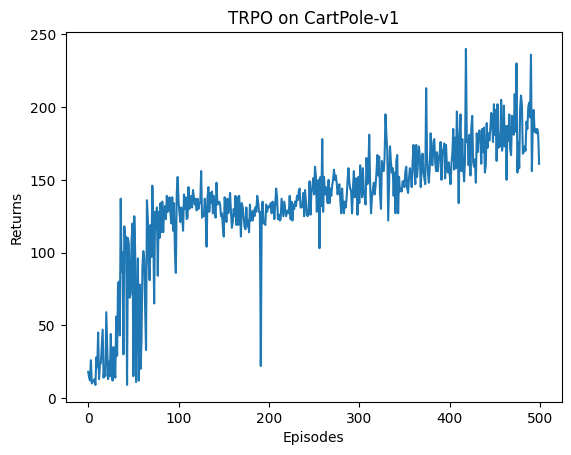

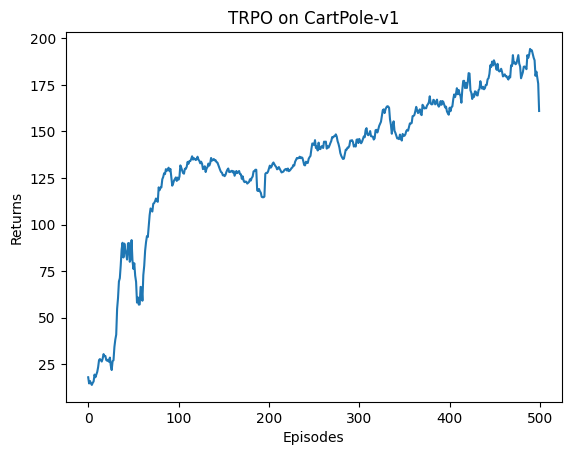

In [4]:
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
critic_lr = 1e-2
kl_constraint = 0.0005
alpha = 0.5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name, render_mode="rgb_array")
_ = env.reset(seed=0)
torch.manual_seed(0)
agent = TRPO(hidden_dim, env.observation_space, env.action_space, lmbda,
             kl_constraint, alpha, critic_lr, gamma, device)
return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

# Iteration 0: 100%|██████████| 50/50 [00:02<00:00, 16.85it/s, episode=50,
# return=139.200]
# Iteration 1: 100%|██████████| 50/50 [00:03<00:00, 16.55it/s, episode=100,
# return=150.500]
# Iteration 2: 100%|██████████| 50/50 [00:03<00:00, 14.21it/s, episode=150,
# return=184.000]
# Iteration 3: 100%|██████████| 50/50 [00:03<00:00, 14.15it/s, episode=200,
# return=183.600]
# Iteration 4: 100%|██████████| 50/50 [00:03<00:00, 13.96it/s, episode=250,
# return=183.500]
# Iteration 5: 100%|██████████| 50/50 [00:03<00:00, 13.29it/s, episode=300,
# return=193.700]
# Iteration 6: 100%|██████████| 50/50 [00:03<00:00, 14.08it/s, episode=350,
# return=199.500]
# Iteration 7: 100%|██████████| 50/50 [00:03<00:00, 13.36it/s, episode=400,
# return=200.000]
# Iteration 8: 100%|██████████| 50/50 [00:03<00:00, 13.33it/s, episode=450,
# return=200.000]
# Iteration 9: 100%|██████████| 50/50 [00:03<00:00, 13.08it/s, episode=500,
# return=200.000]

In [5]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)  ## 用来求每个动作正态分布的均值
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim) ## 用来求每个动作正态分布的方差

    ## 要求出摆动作的概率分布，默认是正态分布的
    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))       ## predict每个动作的正态分布的均值，取值区间则是 [-2, 2]
        std = F.softplus(self.fc_std(x))           ## predict每个动作的正态分布的方差，使用了函数 softplus
        return mu, std  # 高斯分布的均值和标准差

class TRPOContinuous:
    """ 处理连续动作的TRPO算法 """
    def __init__(self, hidden_dim, state_space, action_space, lmbda,
                 kl_constraint, alpha, critic_lr, gamma, device):
        ## 状态的dimension，Pendulum-v1是 3 dim，也就是摆末端的(x,y)坐标，和角速度
        ## https://gymnasium.farama.org/environments/classic_control/pendulum/
        state_dim = state_space.shape[0] ## 3
        action_dim = action_space.shape[0]      ## 1 continuous action，只有一个值，也就是给摆末端施加的 力矩
        self.actor = PolicyNetContinuous(state_dim, hidden_dim,
                                         action_dim).to(device) ##  策略网络不使用传统的 SGD 等梯度下降方式 
        self.critic = ValueNet(state_dim, hidden_dim).to(device)    ##  价值网络仍旧使用SGD ADAM等梯度下降方式 update
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)   ## 价值函数配置优化器
        self.gamma = gamma   ## 衰减因子的呢
        self.lmbda = lmbda  # GAE参数
        self.kl_constraint = kl_constraint  # KL距离最大限制，对策略网络的参数update 做出相应的限制
        self.alpha = alpha  # 线性搜索参数
        self.device = device

    def take_action(self, state): # 根据动作概率分布随机采样
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, std = self.actor(state)      ## 拿到该状态下，均值和标准差
        action_dist = torch.distributions.Normal(mu, std)    ##   配置 好采样的概率
        action = action_dist.sample()       ## 对该状态下，所有的动作采样，采样的分布是高斯分布
        return [action.item()]              ## 返回采样的动作值，也就是力矩的大小

    ## old_action_dists 在传入前已经detach了，不需要反向传播求梯度，是KL散度的梯度
    def hessian_matrix_vector_product(self,
                                      states,
                                      old_action_dists,
                                      vector,
                                      damping=0.1):
        # 计算黑塞矩阵和一个向量的乘积
        mu, std = self.actor(states) ## 拿到该状态下，均值和标准差 
        new_action_dists = torch.distributions.Normal(mu, std)   ##   配置 好采样的概率
        ## 策略网络给出选择动作的概率，然后依概率采样
        ## 算出旧动作选择概率  和  当前动作选择概率的 KL散度，描述了两者的对齐程度，越相似值越小，差异越大值越大
        kl = torch.mean(torch.distributions.kl.kl_divergence(old_action_dists, new_action_dists))
        '''
        反向求策略网络参数的梯度，这是1阶导数的呢 
        https://pytorch.org/docs/stable/generated/torch.autograd.grad.html?highlight=grad#torch.autograd.grad
        torch.autograd.grad(output, input, ......)
        create_graph=True，产生求梯度的图，允许求更高阶的导数，像二阶导数
        kl：kl散度，也就是可导运算的输出，
        self.actor.parameters()：策略网络的参数，也就是可导运算的输入，最后会返回该输入的梯度，而且梯度不会累加到参数的.grad变量，会直接返回的
        '''
        ##  此时反向传播求出的是 self.actor参数的梯度，也就是一阶偏导数，kl_grad: KL ---> new_action_dists ---> self.actor
        kl_grad = torch.autograd.grad(kl, self.actor.parameters(), create_graph = True)
        kl_grad_vector = torch.cat([grad.view(-1) for grad in kl_grad])   ##  一阶梯度全部列化，并且拼起来的
        # KL距离的梯度先和向量进行点积运算
        ## 这样就不需要存储二阶偏导数的矩阵了，向量先和一阶偏导数运算，然后再直接求二阶偏导的，此时二阶偏导也是个向量的，而不是矩阵了
        kl_grad_vector_product = torch.dot(kl_grad_vector, vector)
        '''
        求策略网络参数的二阶导数，也就是二阶梯度，此时二阶偏导也是个向量的，而不是矩阵了
        grad2:   kl_grad_vector_product--->kl_grad_vector--->KL ---> new_action_dists ---> self.actor
        '''
        grad2 = torch.autograd.grad(kl_grad_vector_product, self.actor.parameters())
        grad2_vector = torch.cat([grad.contiguous().view(-1) for grad in grad2])   ##  二阶梯度全部列化，并且拼起来的
        return grad2_vector + damping * vector

    ## https://zhuanlan.zhihu.com/p/657548225
    ## 参数分别是 （grad：当前策略网络的一阶偏导数，states：当前状态的，old_action_dists：当前策略网络的动作分布）
    ## old_action_dists 在传入前已经detach了，不需要反向传播求梯度
    ## Hx = g，g=grad是使用策略网络算广义优势估计时的一阶偏导数，H是算KL散度时的二阶偏导数
    def conjugate_gradient(self, grad, states, old_action_dists):  # 共轭梯度法求解方程
        x = torch.zeros_like(grad)  ##  初始化线性方程组 Hx=g，需要求解的向量x
        r = grad.clone()    ##  复制梯度的，初始化一阶偏导的残差，或者说是一阶偏导数
        p = grad.clone()    ##  复制梯度的，初始化方向向量的
        rdotr = torch.dot(r, r)  ## 初始化 beta 值，用来运算求出 下一个方向向量的，或者用来求出 alpha
        for i in range(10):  # 共轭梯度主循环
            ## 算出 alpha步长 分母需要的内容，p^THp 内的 Hp，也就是KL散度二阶偏导 H 和 优势估计一阶偏导g的的矩阵乘积
            Hp = self.hessian_matrix_vector_product(states, old_action_dists, p)
            ## 算 alpha也就是步长，在方向向量 update 的步长
            alpha = rdotr / torch.dot(p, Hp)
            x += alpha * p  ## update线性方程组 Hx=g 的答案 x，步长是 alpha
            r -= alpha * Hp   ## update 一阶偏导的残差，或者说是一阶偏导数
            new_rdotr = torch.dot(r, r)  ## 用来运算求出 下一个方向向量的，或者用来求出 alpha
            if new_rdotr < 1e-10: ## 基本收敛的，此时alpha 步长也很小了，可以退出循环
                break
            beta = new_rdotr / rdotr  ## 用来运算求出 下一个方向向量的
            p = r + beta * p  ## 求出下一个方向向量的
            rdotr = new_rdotr  ## 赋值
        return x ## 返回 Hx=g 这个线性方程组的答案 x

    def compute_surrogate_obj(self, states, actions, advantage, old_log_probs,
                              actor):  # 计算策略目标
        ## 由于策略可能还没有update，也就是同一个策略，此时的 log_probs = old_log_probs, 像函数 policy_learn内的compute_surrogate_obj
        mu, std = actor(states)
        action_dists = torch.distributions.Normal(mu, std)
        log_probs = action_dists.log_prob(actions)
        ## 若策略还没有update，残差是0，此时取指数就是 ratio = 1，像函数 policy_learn内的compute_surrogate_obj
        ## 也就是 重要性采样，log相减也就是log内相除，最后取指数就是  (当前策略动作的概率 / 旧策略动作的概率)
        ratio = torch.exp(log_probs - old_log_probs)
        '''
        ## 两个策略的动作概率残差取指数，当作优势函数值的权重，均衡当前的广义优势估计，也就是每一步优势的均值
        若 log_probs - old_log_probs > 0，也就是动作概率变大了，则ratio > 1，此时放大了 广义优势估计
        若 log_probs - old_log_probs < 0，也就是动作概率变小了，则ratio < 1，此时缩小了 广义优势估计
        若 log_probs - old_log_probs = 0, 动作概率保持不变的，或者策略还没有update，则ratio = 1, 此时保持不变的
        重要性采样 
        '''
        return torch.mean(ratio * advantage) ## 对广义优势估计做均衡化，并求出平均值

    ## old_log_probs和old_action_dists 在传入前已经detach了，不需要反向传播求梯度
    def line_search(self, states, actions, advantage, old_log_probs,
                    old_action_dists, max_vec):  # 线性搜索
        ## 拿到策略网络的参数，并向量化的，返回参数的向量，这个向量是列向量，也就是只有一列
        old_para = torch.nn.utils.convert_parameters.parameters_to_vector(self.actor.parameters())
        ## 算重要性采样，对广义优势估计做均衡，也就是两个策略的动作概率残差并取指数，当作均衡因子的，也就是重要性采样，用来算出广义优势估计的平均值
        old_obj = self.compute_surrogate_obj(states, actions, advantage,
                                             old_log_probs, self.actor)
        for i in range(15):  # 线性搜索主循环
            coef = self.alpha**i  ## 搜索的相关因子，每次指数次 +1
            new_para = old_para + coef * max_vec   ## 根号 * X，然后coef来调整，拿到update以后的策略网络的参数
            new_actor = copy.deepcopy(self.actor)  ## 深度拷贝的网络
            torch.nn.utils.convert_parameters.vector_to_parameters(
                new_para, new_actor.parameters())  ## 将update以后的网络参数赋值给 深度拷贝的网络
            mu, std = new_actor(states)
            new_action_dists = torch.distributions.Normal(mu, std)  ## update以后网络动作的分布
            kl_div = torch.mean(  ## 算旧网络动作的分布，和update以后网络动作的分布，之间的KL散度，用来判断 KL 散度是否满足要求
                torch.distributions.kl.kl_divergence(old_action_dists,
                                                     new_action_dists))
            ## 使用update以后的策略网络来算重要性采样，然后算广义优势估计，用来判断优势是否上升
            new_obj = self.compute_surrogate_obj(states, actions, advantage,
                                                 old_log_probs, new_actor)
            ## 若优势上升了，并且 KL散度也满足限制条件，就可以退出循环，并返回 update 以后的策略网络的参数
            if new_obj > old_obj and kl_div < self.kl_constraint:
                return new_para
        return old_para ## 若是没找到满足条件的策略参数，那么就返回旧策略的

    '''
    old_log_probs和old_action_dists 在传入前已经detach了，不需要反向传播求梯度
    '''
    def policy_learn(self, states, actions, old_action_dists, old_log_probs,
                     advantage):  # 更新策略函数
        ## 算重要性采样，对广义优势估计做均衡，也就是两个策略的动作概率残差并取指数，当作均衡因子的，也就是重要性采样，用来算出广义优势估计的平均值
        ## 此时策略的参数没有变化，所以此时的均衡因子是一
        surrogate_obj = self.compute_surrogate_obj(states, actions, advantage, old_log_probs, self.actor)
        '''
        对重要性采样以后的广义优势估计的平均值，反向传播求出 策略网络 self.actor 参数的梯度
        也就是 self.compute_surrogate_obj 函数内 log_probs = torch.log(actor(states).gather(1, actions)) 的梯度
        拿到优势估计策略网络参数的 一阶偏导数
        '''
        grads = torch.autograd.grad(surrogate_obj, self.actor.parameters())
        ## 对优势估计策略网络参数的一阶偏导数，列化，然后拼在一起的
        obj_grad = torch.cat([grad.view(-1) for grad in grads]).detach()
        
        '''
        求出线性方程组的解，不需要存储二阶偏导数的矩阵
        参数分别是 （obj_grad：当前策略网络的一阶偏导数，states：当前状态的，old_action_dists：当前策略网络的动作分布）
        old_action_dists 在传入前已经detach了，不需要反向传播求梯度
        '''
        # 用共轭梯度法计算x = H^(-1)g
        ## Hx = g，g=grad是使用策略网络算广义优势估计时的一阶偏导数，H是算KL散度时的二阶偏导数
        ## obj_grad 也就是使用策略网络在重要性采样广义优势估计时的一阶偏导数 g
        descent_direction = self.conjugate_gradient(obj_grad, states,
                                                    old_action_dists)
        ## Hx   x^THx 内的 Hx，也就是KL散度二阶偏导 H 和 上面求出的线性方程组的答案 x，做矩阵运算的
        Hd = self.hessian_matrix_vector_product(states, old_action_dists, descent_direction)
        ## 求出策略网络参数 update 的步长，也就是根号内的内容
        max_coef = torch.sqrt(2 * self.kl_constraint / (torch.dot(descent_direction, Hd) + 1e-8))
        ## descent_direction * max_coef 是策略网络参数 update 时的内容，也就是 根号 * X
        new_para = self.line_search(states, actions, advantage, old_log_probs,
                                    old_action_dists,
                                    descent_direction * max_coef)  # 线性搜索
        torch.nn.utils.convert_parameters.vector_to_parameters(
            new_para, self.actor.parameters())  # 用线性搜索后的参数更新策略

    def update(self, transition_dict):
        ## 拿到这条序列内的 奖励、状态和动作，下一个状态、是否完成的
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = (rewards + 8.0) / 8.0  # 对奖励进行修改,方便训练
        ## 用下个状态求下一个状态的状态动作价值，然后间接求出当前状态的状态动作价值
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)  ## 间接求出的价值 - 直接求出的当前状态的状态动作价值，也就是 TD-error，或者是优势函数 A
        ## 直接求出当前状态的状态动作价值，和 间接求出的价值，使用 MSE 来算损失函数的，不反向传播求梯度，detach
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))
        self.critic_optimizer.zero_grad()      ## 价值网络的优化器置零的
        critic_loss.backward()  ## 价值网络的损失loss反向传播梯度
        self.critic_optimizer.step()   # 更新价值函数
        
        ##  算出优势函数值   广义优势估计，也就是平均值的
        advantage = compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        mu, std = self.actor(states)  ## 拿到 continuous 动作分布的均值和方差
         ## 所有动作概率的分布，不反向传播求梯度，detach，给定正态分布的均值和方差，产生正态分布的
        old_action_dists = torch.distributions.Normal(mu.detach(),
                                                      std.detach())
        ## 从产生的正态分布，给出每个动作的概率 log 值
        old_log_probs = old_action_dists.log_prob(actions)
        # 更新策略函数 ## 不使用优化器来update，而是直接算的
        self.policy_learn(states, actions, old_action_dists, old_log_probs,
                          advantage)

Iteration 9: 100%|████████████████████████████████████| 200/200 [00:24<00:00,  8.33it/s, episode=2000, return=-366.641]


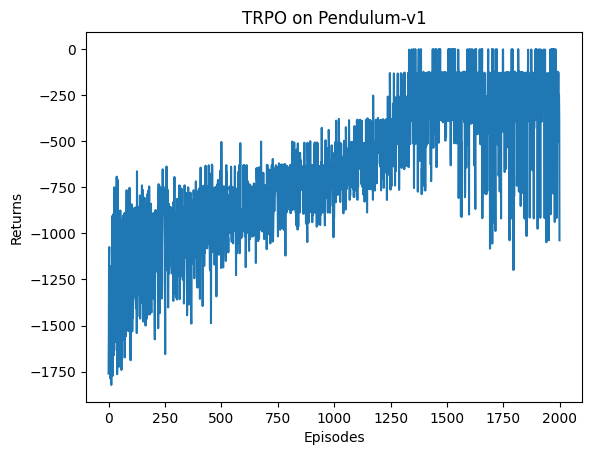

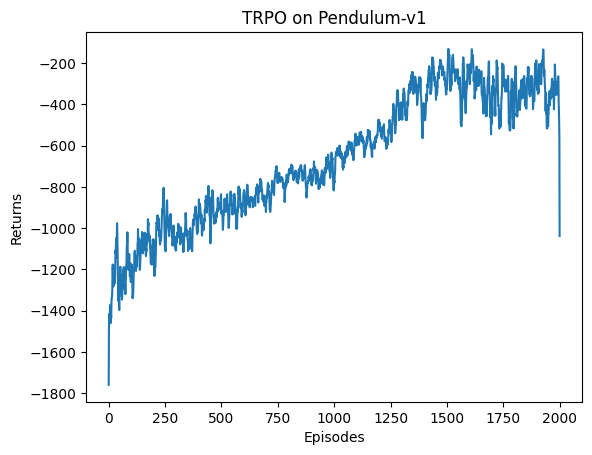

In [6]:
num_episodes = 2000
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
critic_lr = 1e-2
kl_constraint = 0.00005
alpha = 0.5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name, render_mode="rgb_array")
_ = env.reset(seed=0)
torch.manual_seed(0)
agent = TRPOContinuous(hidden_dim, env.observation_space, env.action_space,
                       lmbda, kl_constraint, alpha, critic_lr, gamma, device)
return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

# Iteration 0: 100%|██████████| 200/200 [00:19<00:00, 10.00it/s, episode=200,
# return=-1181.390]
# Iteration 1: 100%|██████████| 200/200 [00:20<00:00,  9.98it/s, episode=400,
# return=-994.876]
# Iteration 2: 100%|██████████| 200/200 [00:20<00:00,  9.86it/s, episode=600,
# return=-888.498]
# Iteration 3: 100%|██████████| 200/200 [00:20<00:00,  9.94it/s, episode=800,
# return=-848.329]
# Iteration 4: 100%|██████████| 200/200 [00:20<00:00,  9.87it/s, episode=1000,
# return=-772.392]
# Iteration 5: 100%|██████████| 200/200 [00:20<00:00,  9.91it/s, episode=1200,
# return=-611.870]
# Iteration 6: 100%|██████████| 200/200 [00:20<00:00,  9.89it/s, episode=1400,
# return=-397.705]
# Iteration 7: 100%|██████████| 200/200 [00:20<00:00,  9.95it/s, episode=1600,
# return=-268.498]
# Iteration 8: 100%|██████████| 200/200 [00:20<00:00,  9.87it/s, episode=1800,
# return=-408.976]
# Iteration 9: 100%|██████████| 200/200 [00:19<00:00, 10.08it/s, episode=2000,
# return=-296.363]